In [1]:
import pandas as pd
import numpy as np
import torch

import json
from pathlib import Path

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
from pyciemss.utils import get_tspan
from pyciemss.utils.interface_utils import convert_to_output_format


In [2]:
def tensor_load(path):
    with open(path) as f:
        data = json.load(f)

    data = {k: torch.from_numpy(np.array(v)) for k, v in data.items()}

    return data

In [3]:
# Load cached data...
tspan = get_tspan(1, 50, 500).detach().numpy()

root = Path("..")/".."/"test"/"data/"
prior_samples = convert_to_output_format(tensor_load(root/"prior_samples.json"), 
                                         tspan, time_unit="years")
observed_trajectory = convert_to_output_format(tensor_load(root/"observed_trajectory.json"), 
                                               tspan, time_unit="years")

observed_points = (observed_trajectory
    .rename(columns={"Rabbits_sol": "Rabbits Samples"})
    .drop(columns=["Wolves_sol", "alpha_param", "beta_param", "delta_param", "gamma_param"])
    .iloc[::10]
)


In [4]:
schema = plots.trajectories(
    prior_samples,
    keep=".*_sol",
    points=observed_points)
points = pd.DataFrame(vega.find_named(schema["data"], "points")["values"])
print(points.columns)



Index(['timepoint', 'sample_id', 'trajectory', 'value'], dtype='object')


In [5]:
vega.find_named(schema["data"], "traces")["values"]

[]

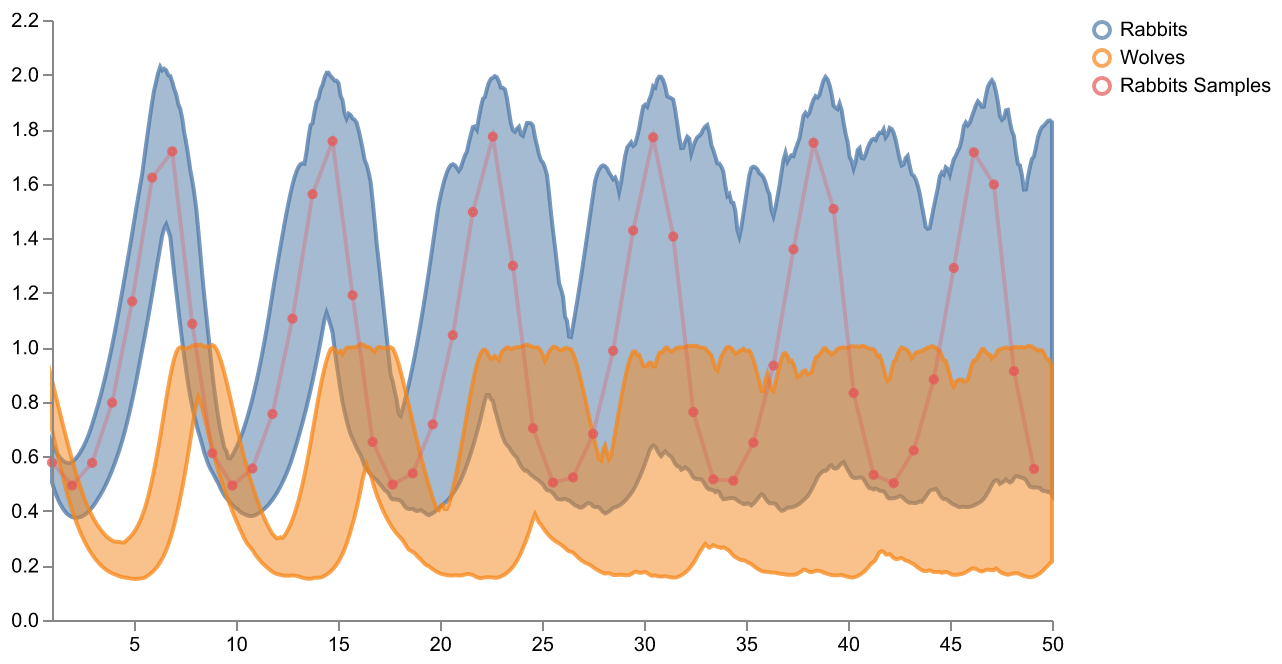

In [6]:
nice_labels={"Rabbits_sol": "Rabbits", "Wolves_sol": "Wolves"}

schema = plots.trajectories(prior_samples, 
                           keep=".*_sol", 
                           relabel=nice_labels,
                           points=observed_points
                           )
schema = plots.pad(schema, 5)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [7]:
exemplars = prior_samples[prior_samples["sample_id"] == 0]
wolves = exemplars.set_index("timepoint_years")["Wolves_sol"].rename("Wolves Example")
rabbits = exemplars.set_index("timepoint_years")["Rabbits_sol"].rename("Rabbits Example")
traces = pd.concat([wolves, rabbits], axis="columns")
nice_labels={"Rabbits_sol": "Rabbits", "Wolves_sol": "Wolves"}
colors = {"Rabbits": "#aec7e8", 
          "Wolves": "#fdae6b",  
          "Wolves Example": "#ff7f0e",
          "Rabbits Example": "#1f77b4",
          "trash": "black", 
          "gamma": None}

schema = plots.trajectories(prior_samples,
                           traces=traces, 
                           relabel=nice_labels,
                           colors=colors,
                           markers={"Confident": 10, "Uncertain": 25}
                           )
schema = plots.pad(schema, 5)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, format="interactive")